<a href="https://colab.research.google.com/github/rahiakela/advanced-natural-language-processing-with-tensorflow-2/blob/main/3-named-entity-recognition/1_named_entity_recognition_with_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Named Entity Recognition with BiLSTM

One of the fundamental building blocks of NLU is **Named Entity Recognition
(NER)**. The names of people, companies, products, and quantities can be tagged in a piece of text with NER, which is very useful in chatbot applications and many other use cases in information retrieval and extraction.

Building and training a model capable of doing NER requires several techniques, such as **Conditional Random Fields (CRFs)** and **Bi-directional LSTMs(BiLSTMs)**.



## Named Entity Recognition

Given a sentence or a piece of text, the objective of an NER model is to locate and classify text tokens as named entities in categories such as people's names, organizations and companies, physical locations, quantities, monetary quantities, times, dates, and even protein or DNA sequences. 

NER should tag the following sentence:

```
Ashish paid Uber $80 to go to the Twitter offices in San Francisco.
```

as follows:

$$
[Ashish]_{PER} \space paid \space [Uber]_{ORG} \space [$80]_{MONEY} \space to \space go \space to \space the \space [Twitter]_{ORG} \space offices \space in \space [San Francisco]_{LOC}.
$$

The most common tags are listed in the table below:

| **Type** | Example Tag | Example |
|---|---|---|
| Person | PER | Gregory went to the castle. |
| Organization | ORG | WHO just issued an epidemic advisory.|
| Location | LOC | She lives in Seattle. |
| Money | MONEY | You owe me twenty dollars. |
| Percentage | PERCENT | Stocks have risen 10% today. |
| Date | DATE | Let's meet on Wednesday. |
| Time | TIME | Is it 5 pm already? |

There are different data sets and tagging schemes that can be used to train NER models. Different data sets will have different subsets of the tags.

There are a few different ways to build an NER model. If the sentence is considered a sequence, then this task can be modeled as a word-by-word labeling task.

Hence, models similar to the models used for Part of Speech (POS) tagging are applicable. Features can be added to a model to improve labeling. The POS of a word and its neighboring words are the most straightforward features to add. Word shape features that model lowercase letters can add a lot of information, principally because a lot of the entity types deal with proper nouns, such as those for people and organizations.

Another vital feature involves checking a word in a gazetteer. A gazetteer is like a database of important geographical entities.

## Setup

In [ ]:
!pip install tensorflow-addons

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd

import os
import csv
import collections
import glob
import matplotlib.pyplot as plt

tf.__version__

'2.4.1'

In [3]:
tfds.__version__

'4.0.1'

In [4]:
######## GPU CONFIGS FOR RTX 2070 ###############
## Please ignore if not training on GPU       ##
## this is important for running CuDNN on GPU ##

tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
# only if you want to see how commands are executed, uncomment below
# tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################

1 Physical GPUs, 1 Logical GPU


In [ ]:
%%shell

wget https://gmb.let.rug.nl/releases/gmb-2.2.0.zip

# !unzip -o gmb-2.2.0.zip  <= use the -o to expand and overwrite whtout prompting
unzip gmb-2.2.0.zip
rm -rf gmb-2.2.0.zip

## Loading the data

**The GMB data set**

With all the basics in the bag, we are ready to build a model that classifies NERs. For this task, the Groningen Meaning Bank (GMB) data set will be used. This dataset is not considered a gold standard.

Also note that since we are going to be working on large data sets, some of the following steps may take some time to execute. In the world of Natural Language Processing (NLP), more training data and training time is key to great results.

The data subfolder has a number of subfolders with different files. README supplied with the data set provides details about the various files and their contents. For this example, we will be using only files named en.tags in various subdirectories. These files are tab-separated files with
each word of a sentence in a row.

Out of lots of fields, we are going to use only the token and the named entity tag.

In [6]:
data_root = './gmb-2.2.0/data/'

fnames = []
for root, dirs, files in os.walk(data_root):
    for filename in files:
        if filename.endswith(".tags"):
            fnames.append(os.path.join(root, filename))

In [7]:
fnames[:2]

['./gmb-2.2.0/data/p00/d0551/en.tags', './gmb-2.2.0/data/p00/d0027/en.tags']

A few processing steps need to happen. Each file has a number of sentences, with each words in a row. The entire sentence as a sequence and the corresponding sequence of NER tags need to be fed in as inputs while training the model. As mentioned, the NER tags also need to be simplified to the top-level entities only. Secondly, the NER tags need to be converted to the IOB format. IOB stands for In-Other-Begin. These letters are used as a prefix to the NER tag. The sentence fragment in the table below shows how this scheme works:

```
Reverend Terry Jones arrived in New    York
B-per    I-per I-per O       O  B-geo  I-geo
```

Note that New York
is one location. As soon as New is encountered, it marks the start of the geo NER
tag, hence it is assigned B-geo. The next word is York, which is a continuation of
the same geographical entity. For any network, classifying the word New as the
start of the geographical entity is going to be very challenging. However, a BiLSTM
network would be able to see the succeeding words, which helps quite a bit with
disambiguation.



In [8]:
# First, create a directory to store all the processed files
!mkdir ner

We want to process the tags so that we strip the subcategories of the NER tags out. It would also be nice to collect some stats on the types of tags in the documents.

In [9]:
ner_tags = collections.Counter()
iob_tags = collections.Counter()


def strip_ner_subcat(tag):
  # NER tags are of form {cat}-{subcat} eg tim-dow. We only want first part
  return tag.split("-")[0]

The next method takes a sequence of tags and converts them into IOB format.

In [10]:
def iob_format(ners):
  # converts IO tags into IOB format
  # input is a sequence of IO NER tokens
  # convert this: O, PERSON, PERSON, O, O, LOCATION, O
  # into: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
  iob_tokens = []

  for idx, token in enumerate(ners):
    if token != "O":    # !other
      if idx == 0:
        token = "B-" + token  # start of sentence
      elif ners[idx - 1] == token:
        token = "I-" + token  # continues
      else:
        token = "B-" + token

    iob_tokens.append(token)
    iob_tags[token] += 1
  return iob_tokens

Once these two convenience functions are ready, all the tags files need to be read and processed.

In [ ]:
total_sentences = 0
outfiles = []

for idx, file in enumerate(fnames):
  with open(file, "rb") as content:
    data = content.read().decode("utf-8").strip()
    sentences = data.split("\n\n")
    print(idx, file, len(sentences))
    total_sentences += len(sentences)

    with open("./ner/" + str(idx) + "-" + os.path.basename(file), "w") as outfile:
      outfiles.append("./ner/" + str(idx) + "-" + os.path.basename(file))
      writer = csv.writer(outfile)

      for sentence in sentences:
        toks = sentence.split("\n")
        words, pos, ner = [], [], []
        for tok in toks:
          t = tok.split("\t")
          words.append(t[0])
          pos.append(t[1])
          ner_tags[t[3]] += 1
          ner.append(strip_ner_subcat(t[3]))
      
      writer.writerow([" ".join(words), " ".join(iob_format(ner)), " ".join(pos)])

Files are read and split into two empty newline characters. That is the marker
for the end of a sentence in the file. Only the actual words, POS tokens, and NER tokens are used from the file. Once these are collected, a new CSV file is written with three columns: the sentence, a sequence of POS tags, and a sequence of NER tags.

In [12]:
print("total number of sentences:", total_sentences)

total number of sentences: 62010


To confirm the distribution of the NER tags before and after processing.

In [13]:
print(ner_tags)
print(iob_tags)

Counter({'O': 1146068, 'geo-nam': 58388, 'org-nam': 48034, 'per-nam': 23790, 'gpe-nam': 20680, 'tim-dat': 12786, 'tim-dow': 11404, 'per-tit': 9800, 'per-fam': 8152, 'tim-yoc': 5290, 'tim-moy': 4262, 'per-giv': 2413, 'tim-clo': 891, 'art-nam': 866, 'eve-nam': 602, 'nat-nam': 300, 'tim-nam': 146, 'eve-ord': 107, 'per-ini': 60, 'org-leg': 60, 'per-ord': 38, 'tim-dom': 10, 'art-add': 1, 'per-mid': 1})
Counter({'O': 177805, 'B-geo': 7364, 'B-org': 4017, 'B-tim': 3734, 'B-per': 3195, 'I-per': 2983, 'B-gpe': 2769, 'I-org': 2575, 'I-geo': 1349, 'I-tim': 1336, 'B-art': 96, 'I-art': 77, 'B-eve': 51, 'I-gpe': 47, 'I-eve': 37, 'B-nat': 32, 'I-nat': 5})


As is evident, some tags were very infrequent, like tim-dom. It would be next to impossible for a network to learn them. Aggregating up one level helps increase the signal for these tags.

In [14]:
labels, values = zip(*iob_tags.items())

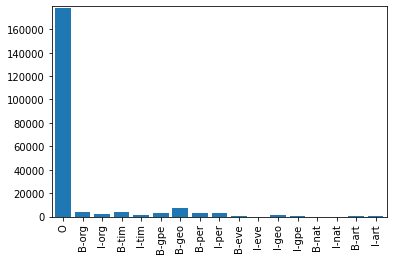

In [15]:
indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks  (indexes, labels, rotation="vertical")
plt.margins(0.01)
plt.subplots_adjust(bottom=0.15)
plt.show()

## Normalizing and vectorizing data

For this, pandas and numpy methods will be used. The first step is to load the contents of the processed files into one DataFrame.

In [17]:
# could use `outfiles` param as well
files = glob.glob("./ner/*.tags")

data_pd = pd.concat([pd.read_csv(f, header=None, names=["text", "label", "pos"]) for f in files], ignore_index=True)

This step may take a while given that it is processing 10,000 files. Once the content is loaded, we can check the structure of the DataFrame:

In [18]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  object
 2   pos     10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


Both the text and NER tags need to be tokenized and encoded into numbers for
use in training. We are going to be using core methods provided by the keras.
preprocessing package. 

First, the tokenizer will be used to tokenize the text. In this example, the text only needs to be tokenized by white spaces, as it has been broken
up already:

In [32]:
text_token = Tokenizer(filters="[\\]^\t\n", lower=False, split=" ", oov_token="<OOV>")
pos_token = Tokenizer(filters="\t\n", lower=False, split=" ", oov_token="<OOV>")
ner_token = Tokenizer(filters="\t\n", lower=False, split=" ", oov_token="<OOV>")

text_token.fit_on_texts(data_pd["text"])
pos_token.fit_on_texts(data_pd["pos"])
ner_token.fit_on_texts(data_pd["label"])

The default values for the tokenizer are quite reasonable. However, in this particular case, it is important to only tokenize on spaces and not clean the special characters out. Otherwise the data will become mis-formatted.

This tokenizer has some useful features. It provides a way to restrict the size of the vocabulary by word counts, TF-IDF, and so on. If the num_words parameter is passed with a numeric value, the tokenizer will limit the number of tokens by word frequencies to that number. The fit_on_texts method takes in all the texts, tokenizes them, and constructs dictionaries with tokens that will be used later to tokenize and encode in one go. 

A convenience function, get_config(), can be called after the tokenizer has been fit on texts to provide information about the tokens:

In [33]:
ner_config = ner_token.get_config()
text_config = text_token.get_config()

print(ner_config)

{'num_words': None, 'filters': '\t\n', 'lower': False, 'split': ' ', 'char_level': False, 'oov_token': '<OOV>', 'document_count': 10000, 'word_counts': '{"O": 177805, "B-geo": 7364, "B-org": 4017, "B-per": 3195, "I-per": 2983, "B-tim": 3734, "B-gpe": 2769, "I-geo": 1349, "I-tim": 1336, "I-org": 2575, "B-eve": 51, "B-art": 96, "I-art": 77, "I-gpe": 47, "I-eve": 37, "B-nat": 32, "I-nat": 5}', 'word_docs': '{"O": 10000, "B-geo": 4730, "B-org": 3129, "B-per": 2580, "I-per": 1993, "B-tim": 3180, "B-gpe": 2282, "I-geo": 1110, "I-tim": 900, "I-org": 1394, "B-eve": 50, "I-art": 37, "B-art": 71, "I-gpe": 41, "I-eve": 25, "B-nat": 27, "I-nat": 5}', 'index_docs': '{"2": 10000, "3": 4730, "4": 3129, "6": 2580, "7": 1993, "5": 3180, "8": 2282, "10": 1110, "11": 900, "9": 1394, "14": 50, "13": 37, "12": 71, "15": 41, "16": 25, "17": 27, "18": 5}', 'index_word': '{"1": "<OOV>", "2": "O", "3": "B-geo", "4": "B-org", "5": "B-tim", "6": "B-per", "7": "I-per", "8": "B-gpe", "9": "I-org", "10": "I-geo", "

The `index_word` dictionary property in the config provides a mapping between
IDs and tokens. There is a considerable amount of information in the config. The vocabularies can be obtained from the config:

In [34]:
text_vocab = eval(text_config["index_word"])
ner_vocab = eval(ner_config["index_word"])

print("Unique words in vocab:", len(text_vocab))
print("Unique NER tags in vocab:", len(ner_vocab))

Unique words in vocab: 15878
Unique NER tags in vocab: 18


Tokenizing and encoding text and named entity labels is quite easy:

In [35]:
x_token = text_token.texts_to_sequences(data_pd["text"])
y_token = ner_token.texts_to_sequences(data_pd["label"])

print(text_token.texts_to_sequences([x_token[1]]), data_pd["text"][1])
print(ner_token.texts_to_sequences([y_token[1]]), data_pd["label"][1])

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]] Mr. Putin is expected to become Russia 's prime minister .
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]] B-per I-per O O O O B-geo O O O O


Since sequences are of different sizes, they will all be padded or truncated to a size of 50 tokens.

In [36]:
max_len = 50

x_pad = sequence.pad_sequences(x_token, padding="post", maxlen=max_len)
y_pad = sequence.pad_sequences(y_token, padding="post", maxlen=max_len)

print(x_pad.shape, y_pad.shape)

(10000, 50) (10000, 50)


In [37]:
text_token.sequences_to_texts([x_pad[1]])

["Mr. Putin is expected to become Russia 's prime minister . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>"]

In [38]:
ner_token.sequences_to_texts([y_pad[1]])

['B-per I-per O O O O B-geo O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

There is an additional step that needs to be performed on the labels. Since there are multiple labels, each label token needs to be one-hot encoded like so:

In [39]:
num_classes = len(ner_vocab) + 1

Y = tf.keras.utils.to_categorical(y_pad, num_classes=num_classes)
Y.shape

(10000, 50, 19)

## A BiLSTM model

The first model we will try is a BiLSTM model. 

First, the basic constants need to be set up:

In [40]:
# Length of the vocabulary
vocab_size = len(text_vocab) + 1

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

# batch size
BATCH_SIZE = 90

# num of NER classes
num_classes = len(ner_vocab) + 1

Next, a convenience function for instantiating models is defined:

In [41]:
dropout = 0.2

def build_model_bilstm(vocab_size, embedding_dim, rnn_units, batch_size, classes):
  model = tf.keras.Sequential([
       Embedding(vocab_size, embedding_dim, mask_zero=True, batch_input_shape=[batch_size, None]),
       Bidirectional(LSTM(units=rnn_units, return_sequences=True, dropout=dropout, kernel_initializer=tf.keras.initializers.he_normal())),
       TimeDistributed(Dense(rnn_units, activation="relu")),
       Dense(num_classes, activation="softmax")                      
  ])

  return model

We are going to train our own embeddings. After the embedding layer,
there is a BiLSTM layer, followed by a TimeDistributed dense layer. This last
layer is different from the sentiment analysis model, where there was only a single unit for binary output. 

In this problem, for each word in the input sequence, an NER token needs to be predicted. So, the output has as many tokens as the input sequence. Consequently, output tokens correspond 1-to-1 with input tokens and are classified as one of the NER classes. The TimeDistributed layer provides this capability. 

The other thing to note in this model is the use of regularization. It is important that the model does not overfit the training data. Since LSTMs have high model capacity, using regularization is very important.

Now the model can be compiled:

In [42]:
model = build_model_bilstm(vocab_size=vocab_size, 
                           embedding_dim=embedding_dim,
                           rnn_units=rnn_units,
                           batch_size=BATCH_SIZE,
                           classes=num_classes)
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (90, None, 64)            1016256   
_________________________________________________________________
bidirectional_1 (Bidirection (90, None, 200)           132000    
_________________________________________________________________
time_distributed_1 (TimeDist (90, None, 100)           20100     
_________________________________________________________________
dense_3 (Dense)              (90, None, 19)            1919      
Total params: 1,170,275
Trainable params: 1,170,275
Non-trainable params: 0
_________________________________________________________________


This simplistic model has over 2.6 million parameters!

>If you notice, the bulk of the parameters are coming from the size
of the vocabulary. The vocabulary has 39,422 words. This increases
the model training time and computational capacity required.
One way to reduce this is to make the vocabulary size smaller.
The easiest way to do this would be to only consider words that
have more than a certain frequency of occurrence or to remove
words smaller than a certain number of characters. The vocabulary
can also be reduced by converting all characters to lower case.
However, in NER, case is a very important feature.

This model is ready for training. 

The last thing that is needed is to split the data into train and test sets:

In [43]:
# to enable TensorFlow to process sentences properly
X = x_pad

# create training and testing splits
total_sentences = 62010

test_size = round(total_sentences / BATCH_SIZE * 0.2)

X_train = X[BATCH_SIZE * test_size:]
Y_train = Y[BATCH_SIZE * test_size:]

X_test = X[0:BATCH_SIZE * test_size]
Y_test = Y[0:BATCH_SIZE * test_size]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(0, 50) (0, 50, 19)
(10000, 50) (10000, 50, 19)


Now, the model is ready for training:

In [ ]:
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=15)

Over 15 epochs of training, the model is doing quite well with over 99% accuracy.

Let's see how the model performs on the test set and whether the regularization helped:

In [ ]:
model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)

The model performs well on the test data set, with over 96.5% accuracy. The
difference between the train and test accuracies is still there, implying that the model could use some additional regularization. 

You can play with the dropout variable or add additional dropout layers between the embedding and BiLSTM layers, and between the TimeDistributed layer and the final Dense layer.

Here is an example of a sentence fragment tagged by this model: